In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
referral = pd.read_csv('../data/referral.csv')

In [26]:
referral.head()

,provider_npi,entity_type,provider_org_name,provider_last_name,provider_first_name,provider_middle_name,provider_name_prefix,provider_name_suffix,provider_credential,provider_address_1,...,code_group,provider_code_class,code_display_name,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,hospital_name,hospital_code_class
0,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Allopathic & Osteopathic Physicians,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine
1,1003013160,1.0,NaN,GRABENSTEIN,WILLIAM,P.,DR.,NaN,M.D.,1822 MEMORIAL DR,...,Allopathic & Osteopathic Physicians,Family Medicine,Family Medicine Physician,1104202761,32,55,37.891,39.275,Vanderbilt,Internal Medicine
2,1003019902,1.0,NaN,ACOSTA,LEALANI,MAE,NaN,NaN,MD,3601 TVC,...,Allopathic & Osteopathic Physicians,Psychiatry & Neurology,Neurology Physician,1104202761,261,406,1.495,9.868,Vanderbilt,Internal Medicine
3,1003050972,1.0,NaN,LENTZ,ROBERT,JAMES,DR.,NaN,M.D.,3601 THE VANDERBILT CLINIC,...,Allopathic & Osteopathic Physicians,Internal Medicine,Pulmonary Disease Physician,1104202761,198,317,0.016,0.202,Vanderbilt,Internal Medicine
4,1003052697,2.0,"SUNCREST HEALTHCARE OF EAST TENNESSEE, LLC",NaN,NaN,NaN,NaN,NaN,NaN,117 E BRYANT ST STE C,...,Agencies,Home Health,Home Health Agency,1104202761,133,182,47.769,57.315,Vanderbilt,Internal Medicine


In [32]:
# top level patient stats by hospital system
top_patient_stats = referral.groupby('hospital_name').agg(total_patients = ('patient_count', 'sum'),
                                      total_transactions = ('transaction_count', 'sum')).reset_index()

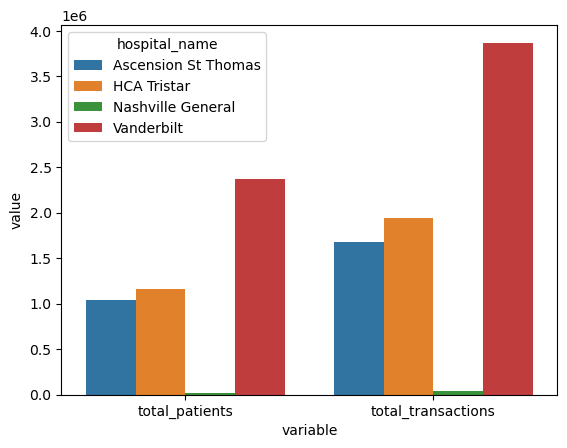

In [40]:
# reshape top patient stats and create grouped barplot

sns.barplot(
    data = top_patient_stats.melt(id_vars = ['hospital_name'], value_vars = ['total_patients', 'total_transactions']),
    y = 'value', x = 'variable', hue = 'hospital_name', errorbar = None
);

# formatting: remove axis labels, add title, change category and legend names, show actual numbers on y-axis, add counts to bars

In [42]:
# transaction to patient ratio (my understanding is that patients can have multiple referrals so a higher ratio could indicate potential for larger referral gains with less work)
top_patient_stats['patient_transaction_referral'] =top_patient_stats['total_transactions'] / top_patient_stats['total_patients']

In [43]:
top_patient_stats

,hospital_name,total_patients,total_transactions,patient_transaction_referral
0,Ascension St Thomas,1045699,1683036,1.609484
1,HCA Tristar,1164866,1940550,1.665900
2,Nashville General,22118,42906,1.939868
3,Vanderbilt,2373032,3871413,1.631420


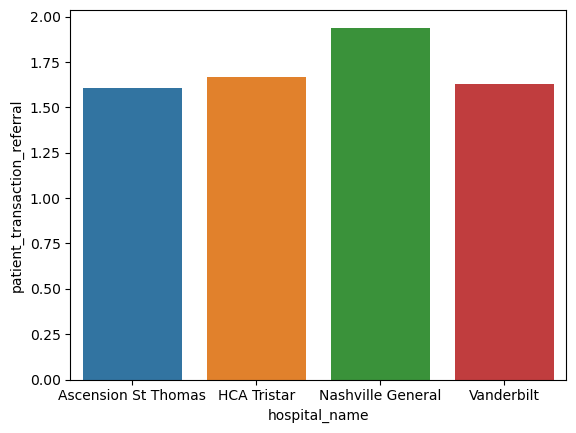

In [44]:
sns.barplot(x = 'hospital_name',
            y = 'patient_transaction_referral',
            data = top_patient_stats);
# formatting: change axis labels, add title, add value number to bars